In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
import seaborn as sns
from geopy import distance

In [2]:
df_train = pd.read_csv("split/train.csv")

In [3]:
df_train.shape

(1000000, 10)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


## We have 10 feathers and 1 target let's go through each attribute briefly:

- id: A unique identifier for each trip. It serves as a primary key to distinguish one trip from another.

- vendor_id: A code indicating the provider associated with the trip record. This could represent different taxi companies or service providers.

- pickup_datetime: The date and time when the meter was engaged, marking the start of the trip.

- passenger_count: The number of passengers in the vehicle. It is a driver-entered value, indicating how many individuals were in the taxi during the trip.

- pickup_longitude: The longitude coordinate where the meter was engaged, i.e., the pickup location.

- dropoff_longitude: The longitude coordinate where the meter was disengaged, i.e., the dropoff location.

- dropoff_latitude: The latitude coordinate where the meter was disengaged, i.e., the dropoff location.

- store_and_fwd_flag: This flag indicates whether the data was sent to the vendor in real-time ("N") or whether it was stored in the vehicle's memory and sent later when a connection was available ("Y").

- trip_duration: The duration of the trip in seconds, i.e., the time between the pickup and dropoff.
**Note : trip_duration is our target Variable.**

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


#### 1. `vendor_id`
- Only two possible values: **1 or 2** (categorical).
- Distribution is slightly skewed toward vendor **2** (mean ≈ 1.54).
- Should be treated as a **categorical feature**, not numeric.

#### 2. `passenger_count`
- Range: **0 to 7**.
- Typical trips: **1–2 passengers** (median = 1, 75% quantile = 2).
- **Potential issues:**
  - `0` passengers → invalid trips.
  - High values (6–7) are rare and could be anomalies.

#### 3. `pickup_longitude` & `pickup_latitude`
- Central location: around **(-74, 40.75)** → matches **NYC coordinates**.
- Extreme values:
  - Longitude min = **-121.93**, Latitude max = **51.88** → far outside NYC.
- **Most values are tightly clustered around NYC**, but outliers exist and need filtering.

#### 4. `dropoff_longitude` & `dropoff_latitude`
- Similar distribution to pickup points.
- Central cluster: **NYC region**.
- Extreme outliers outside valid NYC bounds.
- Filtering required to keep only realistic trips.

#### 5. `trip_duration`
- Mean = **955 seconds (~16 minutes)**.
- Median = **662 seconds (~11 minutes)**.
- Distribution is **right-skewed** (long trips pull the mean up).
- Extreme values:
  - Min = **1 second** → unrealistic.
  - Max = **2,227,612 seconds (~25 days)** → unrealistic (outlier).

In [6]:
# First lets log trip duration

df_train['trip_duration'] = np.log1p(df_train['trip_duration'])

## Lets analyze each feature with target feature

1. **Vendor id**

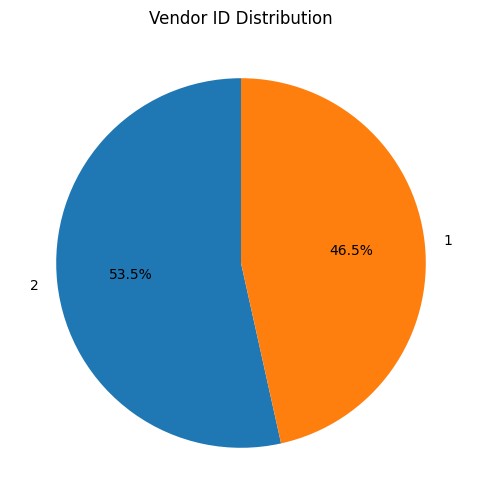

In [8]:
df_train['vendor_id'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6))
plt.title("Vendor ID Distribution")
plt.ylabel("")  # remove y-label
plt.show()

**They are nearly equal in counts**

2. **Passenger count**

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5416\545103476.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="passenger_count", palette="Set2")


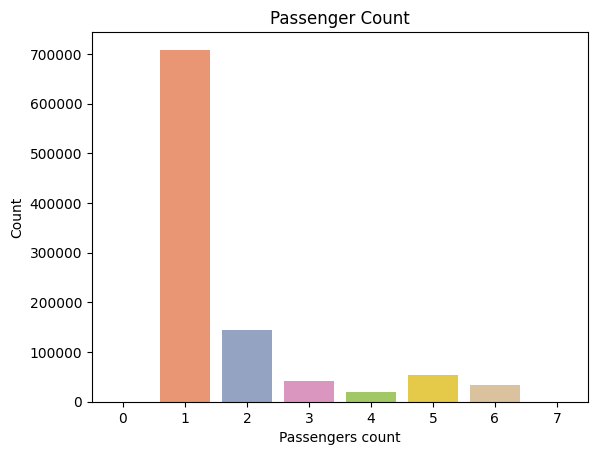

In [9]:
sns.countplot(data=df_train, x="passenger_count", palette="Set2")
plt.title("Passenger Count")
plt.xlabel("Passengers count")
plt.ylabel("Count")
plt.show()

In [10]:
df_train['passenger_count'].value_counts()

passenger_count
1    708628
2    143907
5     53635
3     41012
6     33287
4     19491
0        38
7         2
Name: count, dtype: int64

**Most of trips is for one passenger only**

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5416\1014825074.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="vendor_id", y='trip_duration', palette='hot', ax=ax1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5416\1014825074.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x= "passenger_count", y= 'trip_duration', palette='magma', ax=ax2)


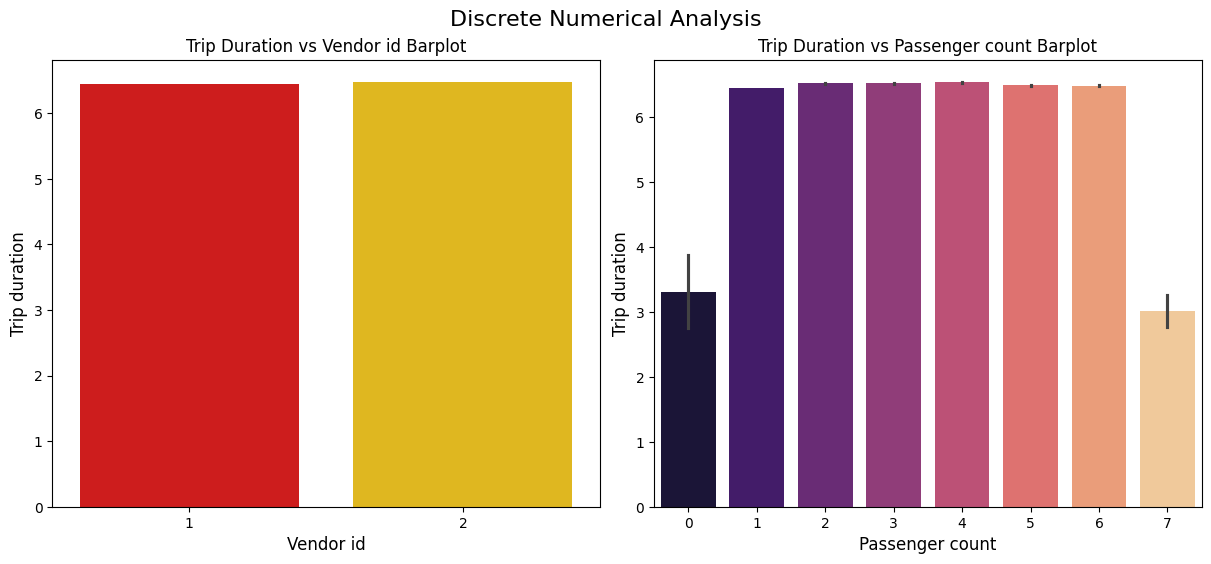

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(12, 10))
gs = GridSpec(2, 2, figure=fig)

# Subplot 1: Bar Plot for vendor_id
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=df_train, x="vendor_id", y='trip_duration', palette='hot', ax=ax1)
ax1.set_title('Trip Duration vs Vendor id Barplot')
ax1.set_xlabel("Vendor id", fontsize=12)
ax1.set_ylabel("Trip duration", fontsize=12)

# Subplot 2: Bar Plot for passenger_count
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data=df_train, x= "passenger_count", y= 'trip_duration', palette='magma', ax=ax2)
ax2.set_title('Trip Duration vs Passenger count Barplot')
ax2.set_xlabel("Passenger count", fontsize=12)
ax2.set_ylabel("Trip duration", fontsize=12)

# Add a title for the entire figure
fig.suptitle("Discrete Numerical Analysis", fontsize=16)

# Show the plots
plt.show()

Clearly vendor_id will not make big difference model training so its not very important feature and also passenger count not important feature as they are nearly the same in trip duration

3. **Datetime features**

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5416\3171248810.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="Season", y='trip_duration', palette='hot', ax=ax1)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5416\3171248810.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= df_train, x="hour",  y= 'trip_duration', palette='magma', ax=ax2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5416\3171248810.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x="month", y= 'trip_duration

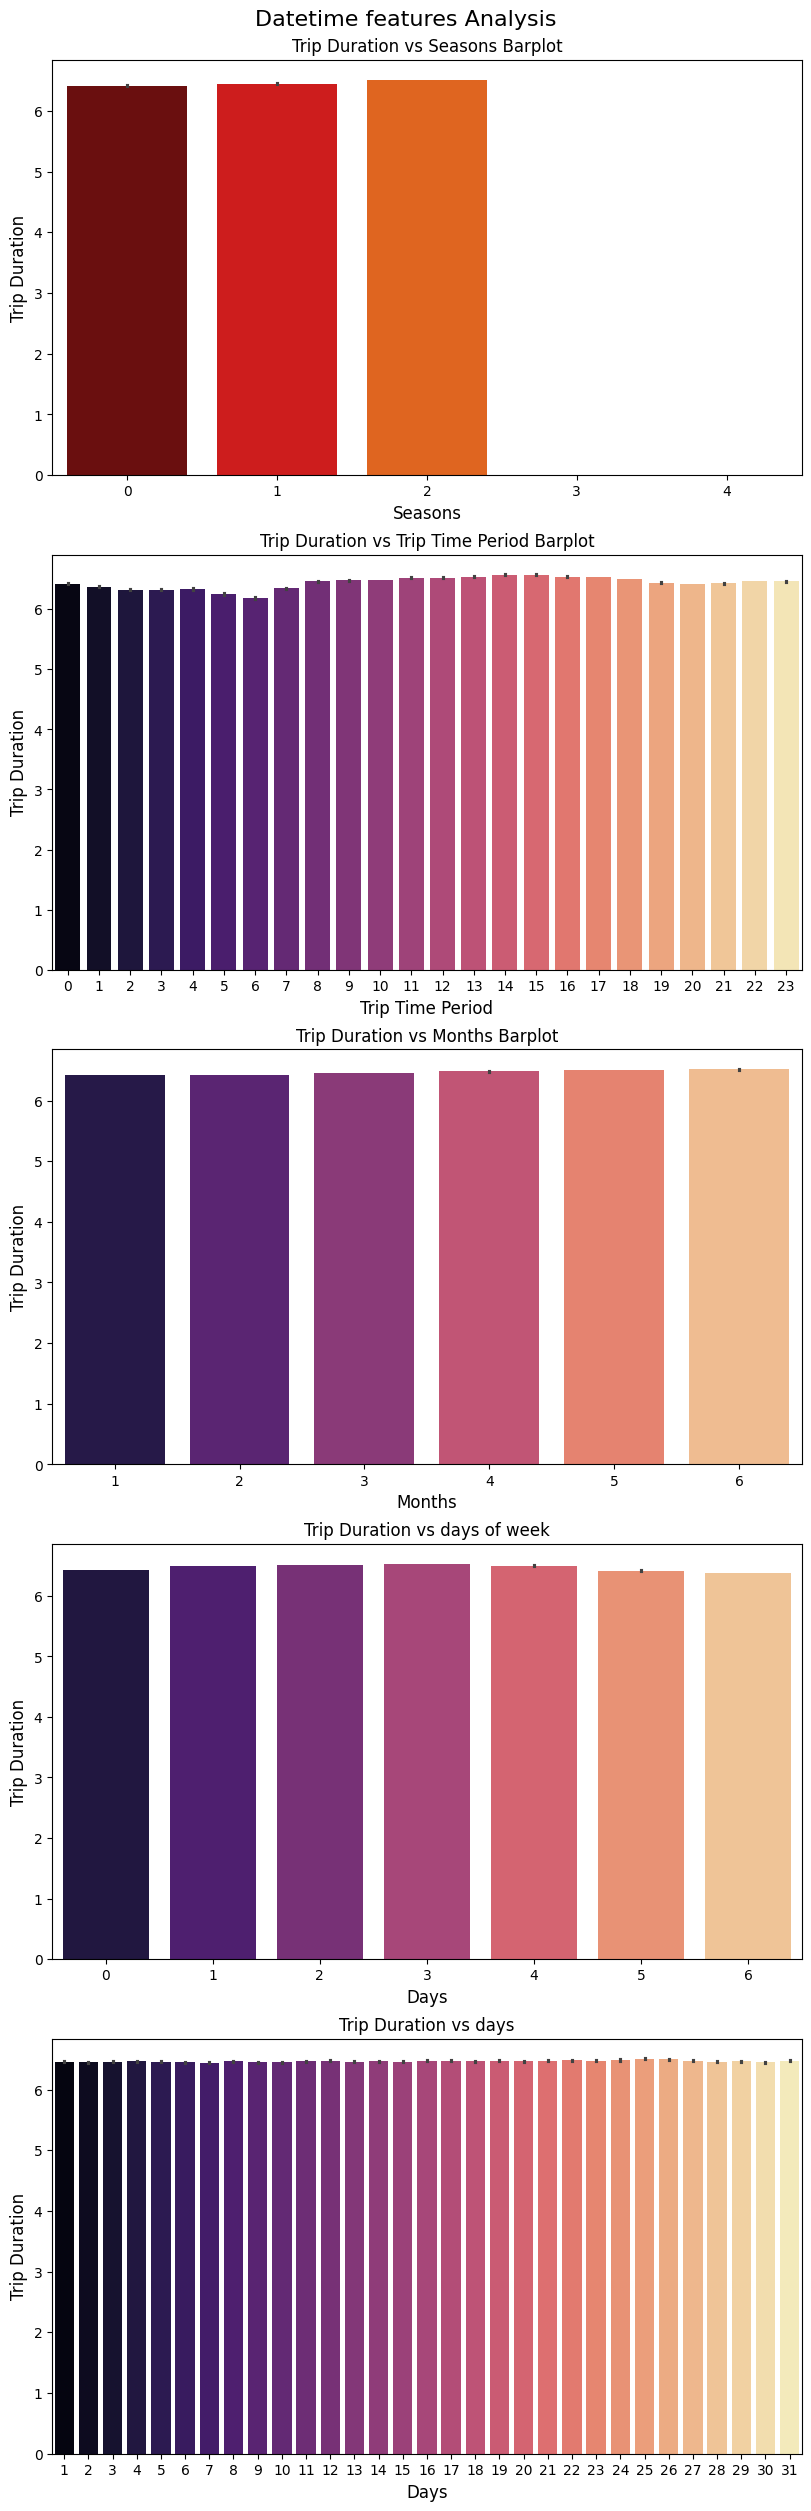

In [16]:
bins = [0, 2, 5, 8, 11, 12]  # 0, 2, 5, 8, 11, 12 represent the starting and ending months of each season
labels = ['0', '1', '2', '3', '4'] # Labels for each season ['Winter', 'Spring', 'Summer', 'Autumn', 'Winter'] 

df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])

df_train["hour"] = df_train["pickup_datetime"].dt.hour
df_train["day"]  = df_train["pickup_datetime"].dt.day
df_train["dayofweek"] = df_train["pickup_datetime"].dt.dayofweek
df_train["month"]  = df_train["pickup_datetime"].dt.month
df_train['Season'] = pd.cut(df_train["month"] , bins=bins, labels=labels, right=False,ordered=False)

# Create the figure with GridSpec and specify the size
fig = plt.figure(constrained_layout=True, figsize=(8, 25))
gs = GridSpec(5, 1, figure=fig)

# Subplot 1: Bar Plot for Seasons
ax1 = fig.add_subplot(gs[0, :])
sns.barplot(data=df_train, x="Season", y='trip_duration', palette='hot', ax=ax1)
ax1.set_title('Trip Duration vs Seasons Barplot')
ax1.set_xlabel("Seasons", fontsize=12)
ax1.set_ylabel("Trip Duration", fontsize=12)

# Subplot 2: Bar Plot for time period
ax2 = fig.add_subplot(gs[1, :])
sns.barplot(data= df_train, x="hour",  y= 'trip_duration', palette='magma', ax=ax2)
ax2.set_title('Trip Duration vs Trip Time Period Barplot')
ax2.set_xlabel("Trip Time Period", fontsize=12)
ax2.set_ylabel("Trip Duration", fontsize=12)

# Subplot 3: Bar Plot for months
ax3 = fig.add_subplot(gs[2, :])
sns.barplot(data=df_train, x="month", y= 'trip_duration', palette='magma', ax=ax3)
ax3.set_title('Trip Duration vs Months Barplot')
ax3.set_xlabel("Months", fontsize=12)
ax3.set_ylabel("Trip Duration", fontsize=12)

# Subplot 4: Bar Plot for day of week
ax4 = fig.add_subplot(gs[3, :])
sns.barplot(data=df_train, x="dayofweek", y= 'trip_duration', palette='magma', ax=ax4)
ax4.set_title('Trip Duration vs days of week')
ax4.set_xlabel("Days", fontsize=12)
ax4.set_ylabel("Trip Duration", fontsize=12)

# Subplot 5: Bar Plot for days
ax5 = fig.add_subplot(gs[4, :])
sns.barplot(data=df_train, x="day", y= 'trip_duration', palette='magma', ax=ax5)
ax5.set_title('Trip Duration vs days')
ax5.set_xlabel("Days", fontsize=12)
ax5.set_ylabel("Trip Duration", fontsize=12)

# Adjust layout for better appearance
fig.suptitle("Datetime features Analysis", fontsize=16)

# Show the plots
plt.show()

In [13]:
df_train['Season'].value_counts()

Season
1    511480
2    330891
0    157629
3         0
4         0
Name: count, dtype: int64

**All date time features nearly have same trip duration except hour which can help during model training**

4. **Distance features**

In [17]:
numerical_features = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']

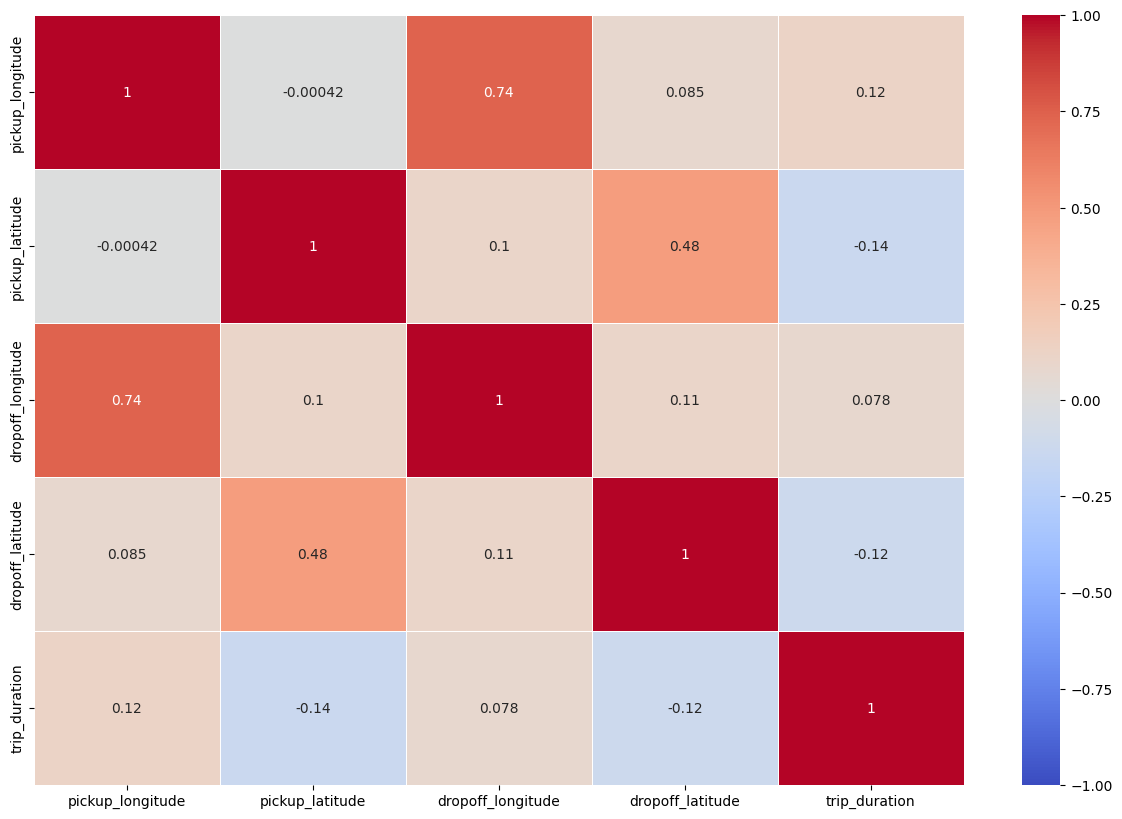

In [18]:
df_corr = df_train[numerical_features]
corr = df_corr.corr()

fig = plt.figure(figsize=(15,10))

sns.heatmap(corr,annot=True,linewidths=.5,cmap='coolwarm',vmin=-1,vmax=1,center=0);

**No Strong correlation here lets start adding some distance features like haversine,manhattan,bearing**

In [27]:
def haversine_distance(df):
    R = 6371.0  # Earth radius in km
    
    lat1 = np.radians(df['pickup_latitude'].values)
    lon1 = np.radians(df['pickup_longitude'].values)
    lat2 = np.radians(df['dropoff_latitude'].values)
    lon2 = np.radians(df['dropoff_longitude'].values)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    dist = R * c  # distance in km
    return np.log1p(dist)

def calculate_direction(df):
    lat1 = np.radians(df['pickup_latitude'].values)
    lon1 = np.radians(df['pickup_longitude'].values)
    lat2 = np.radians(df['dropoff_latitude'].values)
    lon2 = np.radians(df['dropoff_longitude'].values)

    dlon = lon2 - lon1

    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

    bearing = np.degrees(np.arctan2(y, x))
    bearing = (bearing + 360) % 360  # normalize to [0,360)
    return np.log1p(bearing)

def manhattan_distance(df):
    lat1 = np.radians(df['pickup_latitude'].values)
    lat2 = np.radians(df['dropoff_latitude'].values)
    lon1 = np.radians(df['pickup_longitude'].values)
    lon2 = np.radians(df['dropoff_longitude'].values)

    # Approximate conversion: 1 degree latitude ≈ 111 km
    lat_dist = np.abs(df['pickup_latitude'].values - df['dropoff_latitude'].values) * 111
    # Longitude distance depends on latitude
    lon_dist = np.abs(df['pickup_longitude'].values - df['dropoff_longitude'].values) * 111 * np.cos(lat1)

    return np.log1p(lat_dist + lon_dist)

In [28]:
df_train['distance_haversine'] = haversine_distance(df_train)
df_train['direction']          = calculate_direction(df_train)
df_train['distance_manhattan'] = manhattan_distance(df_train)

In [29]:
numerical_features = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance_haversine','direction','distance_manhattan','trip_duration']

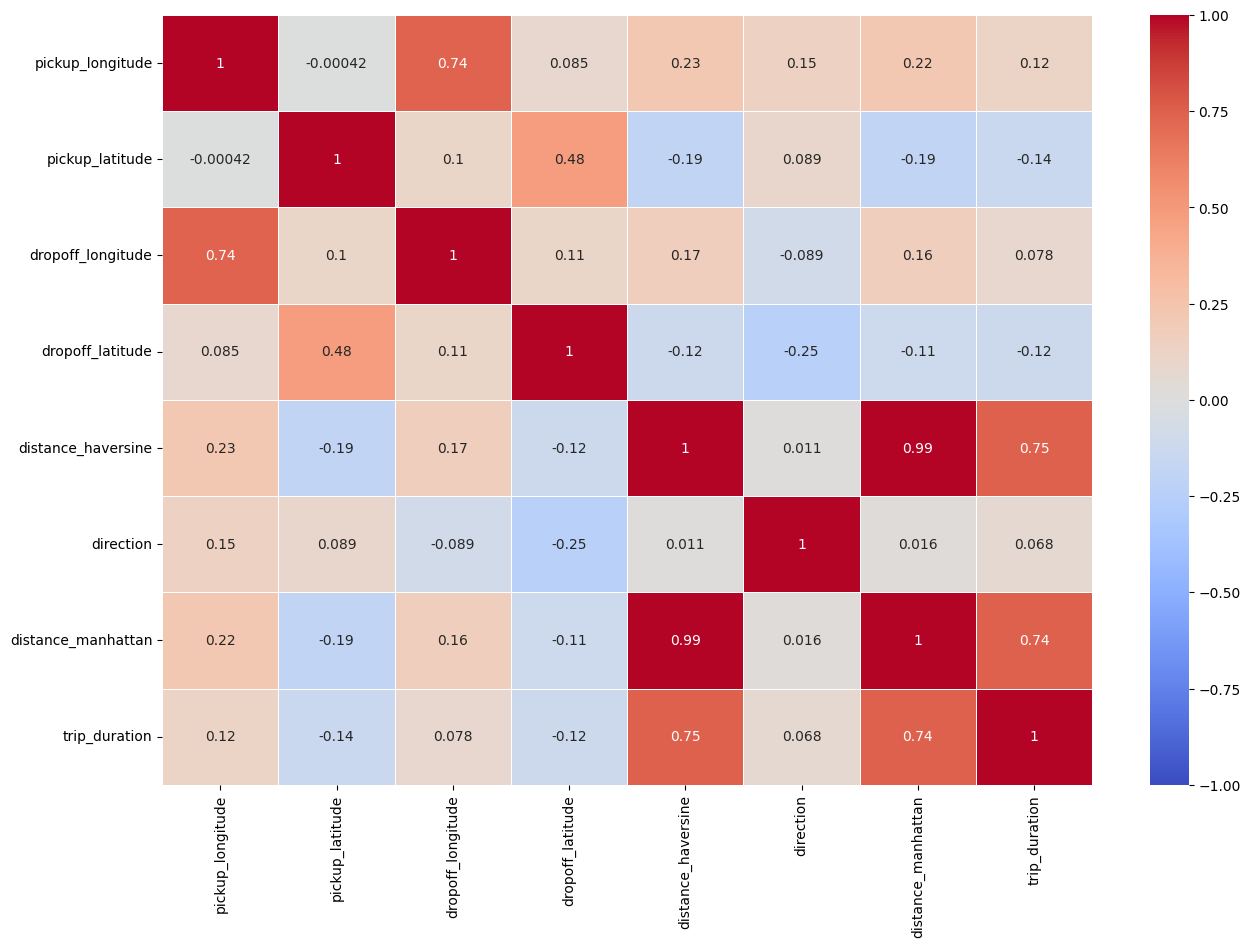

In [30]:
df_corr = df_train[numerical_features]
corr = df_corr.corr()

fig = plt.figure(figsize=(15,10))

sns.heatmap(corr,annot=True,linewidths=.5,cmap='coolwarm',vmin=-1,vmax=1,center=0);

Clearly distance_haversine and distance_manhattan are the most important features for predicting our target feature